# Mini-Challenge 2: Imnage Capting

Firat Saritas, 24.12.2021

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import seaborn as sns
from tqdm import tqdm

from collections import Counter
import spacy #for tokenization 
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

from torchvision import transforms
import torchvision
from PIL import Image

## Ausgangslage:

## 1. Daten

In [2]:
df_captions = pd.read_csv("data/Flickr_8k/captions.txt", sep=',')
df_captions.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [3]:
folder ="data/Flickr_8k/Images/"
volume = os.listdir(folder)
print("\nAnzahl Bilder: {}".format(len(volume)))


Anzahl Bilder: 8091


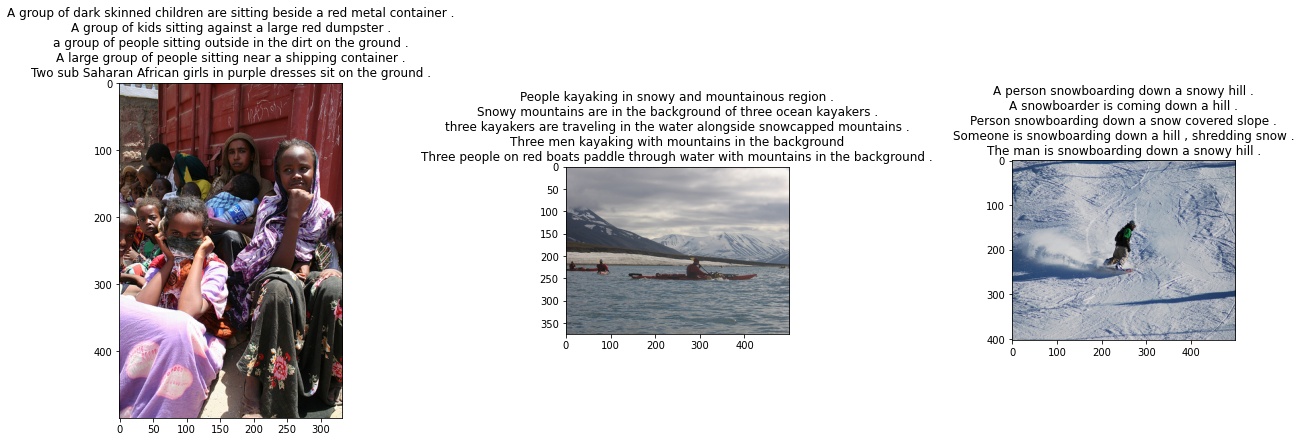

In [4]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=1)
k = 0
random.seed(88)

for i in range(3):
    random_number = random.randint(0, len(df_captions))
    sample = df_captions.iloc[random_number][0]
    sample_path ="data/Flickr_8k/Images/"+sample
    sample_images = df_captions[df_captions['image'] == sample]
    sample_captions = sample_images['caption'].tolist()    
    img=mpimg.imread(sample_path)
    ax=plt.subplot(1,3,k+1)
    ax.title.set_text(sample_captions[0]+ "\n"+ sample_captions[1]+ "\n"+ sample_captions[2]+ "\n"+ sample_captions[3]+ "\n"+ sample_captions[4])
    plt.imshow(img)
    k = k+1    
    

Die Daten stammen von Kaggle und bestehen ca. aus 8'000 Bildern. Die Bilder sind jeweils mit fünf verschiedenen Bildunterschriften gepaart. Bei unseren drei zufälligen Beispielen sehen wir, dass wir unterschiedliche Formate der Bilder haben. Die Sätze beschreiben die Bilder andersartig und gut auf englisch.

In [5]:
cound_df = pd.DataFrame(df_captions.caption.str.split(expand=True).stack().value_counts())
cound_df = cound_df.rename(columns={0:"count"})
cound_df.head(10)

,count
a,40319
.,36577
A,22667
in,18962
the,15328
on,10730
is,9345
and,8850
dog,7984
with,7760


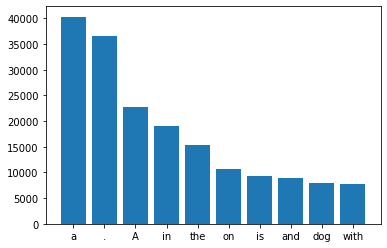

In [6]:
plt.bar(list(cound_df.index)[:10], list(cound_df.head(10).iloc[:,0]))
plt.show()

Wie erwartet sind die häufigsten Wörten die sogenanten "Stopwords". Stopwords sind Wörter, die einem Satz nicht viel Bedeutung hinzufügen. Sie können ignoriert werden, ohne gross die Bedeutung des Satzes zu beeinträchtigen.

## 2. Aufbau Modelierung

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
device

NVIDIA GeForce RTX 3060


device(type='cuda')

### 2.1. Data Loader

In [8]:
# Tokenizer
spacy_eng = spacy.load("en_core_web_sm")

# Index all Words
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} #UNK is Unknown. 
        self.stoi = {"<PAD>": 0, "<SOS>" : 1, "<EOS>": 2, "<UNK>": 3} #stoi= string to index, itos = index to string
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4 #because we have 4 defined further up
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                    
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [9]:
class FlickrDataset(Dataset):
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]] #SOS = Start of Sentence
        caption_vec += self.vocab.numericalize(caption)
        caption_vec.append(self.vocab.stoi["<EOS>"]) #EOS = End of Sentence
        
        return img, torch.tensor(caption_vec)

In [10]:
#ped all to the same length
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [11]:
def image_loader(data_location,caption_location,batch_size=32,num_workers=8,image_size=32,shuffle=True,pin_memory=True):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    dataset = FlickrDataset(data_location, caption_location, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    dataloader = DataLoader(dataset=dataset,batch_size=batch_size,num_workers=num_workers,
        shuffle=shuffle,pin_memory=pin_memory,collate_fn=MyCollate(pad_idx=pad_idx))

    return dataset, dataloader

In [12]:
#setting the constants
data_location =  "data/Flickr_8k/Images/"
caption_location =  "data/Flickr_8k/captions.txt"
batch_size = 32
num_workers = 8
image_size=299

In [13]:
dataset,dataloader = image_loader(data_location=data_location,
                                    caption_location=caption_location,
                                    batch_size = batch_size,
                                    num_workers=num_workers,
                                    image_size=image_size)

In [14]:
dataloader

In [15]:
dataset

def main():
    stopper = 10
    counter = 0
    for index, (imgs, captions) in enumerate(dataloader):
            print(imgs.shape)
            print(captions.shape)
            counter += 1
            if counter == stopper:
                break
if __name__ == "__main__":
    main()        

In [16]:
vocab_size = len(dataset.vocab)
vocab_size

2994

### Defining the Model Architecture

In [17]:
#with transfer learning
resnet = models.resnet50(pretrained=True)

#CNN
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = resnet
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return features
    
#RNN

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers) #lstm = Long short-term memory
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [18]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[index] for index in result_caption]

### Training

In [19]:
def predict(model, device, dataset, img):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()
    test_img = transform(Image.open(img).convert("RGB")).unsqueeze(
        0
    )
    return ("OUTPUT:"+" ".join(model.caption_image(test_img.to(device), dataset.vocab)))


transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [20]:
def save_checkpoint(checkpoint, filename="my_checkpoint.pth.tar"):
    print("==>Saving checkpoint")
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("==>Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    

In [21]:
def train():
    dataset,dataloader = image_loader(data_location=data_location,
                                        caption_location=caption_location,
                                        batch_size = batch_size,
                                        num_workers=num_workers,
                                        image_size=image_size)

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 2

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model and loss
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    model.train()

    for epoch in range(num_epochs):
        if epoch%5 == 0:
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            save_checkpoint(checkpoint)
            
        print("Epoch {}".format(epoch))
        
        for idx, (imgs, captions) in tqdm(
            enumerate(dataloader), total=len(dataloader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1]) #last one open, bc we want to predict them
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
     

    
    reference = [
    'A child in a pink dress is climbing up a set of stairs in an entry way .'.split(),
    'A girl going into a wooden building .'.split(),
    'A little girl climbing into a wooden playhouse .'.split(),
    'A little girl climbing the stairs to her playhouse .'.split(),
    'A little girl in a pink dress going into a wooden cabin'.split()
                ]
    candidate=predict(model, device, dataset, img="../input/flickr8k/Images/1000268201_693b08cb0e.jpg")
    print(candidate)
    print('BLEU score -> {}'.format(sentence_bleu(reference, candidate.split())))
    

In [ ]:
train()

==>Saving checkpoint
Epoch 0


In [ ]:
def predict(model, device, dataset, img):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()
    test_img = transform(Image.open(img).convert("RGB")).unsqueeze(
        0
    )
    return ("OUTPUT:"+" ".join(model.caption_image(test_img.to(device), dataset.vocab)))


transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )


In [ ]:
def save_checkpoint(checkpoint, filename="my_checkpoint.pth.tar"):
    print("==>Saving checkpoint")
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("==>Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    

## 3. Training und Evalutaion

In [ ]:
def image_loader(image_size=299, batch_size=32, root="Images/",num_workers=8,shuffle=False):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_set = FlickrDataset(root_dir=root, captions_file=caption_location,transform=transform)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,pin_memory=True)

    return data_set,data_loader

In [ ]:
def train():
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )


    train_loader,dataset = get_loader(
        root_folder=data_location,
        annotation_file= caption_location,
        transform=transform,
        num_workers=num_workers)
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 30

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN
    model.train()

    for epoch in range(num_epochs):
        if epoch%5 == 0:
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            save_checkpoint(checkpoint)
            
        print("Epoch {}".format(epoch))
        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )
            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
            
    reference = [
    'A child in a pink dress is climbing up a set of stairs in an entry way .'.split(),
    'A girl going into a wooden building .'.split(),
    'A little girl climbing into a wooden playhouse .'.split(),
    'A little girl climbing the stairs to her playhouse .'.split(),
    'A little girl in a pink dress going into a wooden cabin'.split()
                ]
    candidate=predict(model, device, dataset, img="../input/flickr8k/Images/1000268201_693b08cb0e.jpg")
    print(candidate)
    print('BLEU score -> {}'.format(sentence_bleu(reference, candidate.split())))
    


In [ ]:
    if __name__ == "__main__":
        train()

In [ ]:
train()

## 4. Bericht

## 5. Quellenangaben
- https://www.kaggle.com/adityajn105/flickr8k
- https://www.kaggle.com/mdteach/image-captioning-with-attention-pytorch
- https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k
- https://www.youtube.com/watch?v=9sHcLvVXsns&ab_channel=AladdinPersson
- https://www.youtube.com/watch?v=y2BaTt1fxJU&ab_channel=AladdinPersson
